In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [4]:
PATH = "data/future_sales/"

In [5]:
!ls {PATH}

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


## Step 1: Taking a look at the data

First we read in the data CSV and take a look at it to get a general feel for things.

In [104]:
mydateparser = lambda x: pd.datetime.strptime(x, "%d.%m.%Y")
mydateparser('09.08.2014')

datetime.datetime(2014, 8, 9, 0, 0)

In [106]:
mydateparser = lambda x: pd.datetime.strptime(x, "%d.%m.%Y")
df_raw = pd.read_csv(f'{PATH}sales_train.csv', low_memory=False, 
                     parse_dates=["date"], date_parser=mydateparser)

In [107]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [108]:
display_all(df_raw.tail())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,2015-10-10,33,25,7409,299.0,1.0
2935845,2015-10-09,33,25,7460,299.0,1.0
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0
2935848,2015-10-03,33,25,7460,299.0,1.0


In [109]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date,2935849,1034,2013-12-28 00:00:00,9434,2013-01-01 00:00:00,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_block_num,2.93585e+06,NaN,NaN,NaN,NaN,NaN,14.5699,9.42299,0,7,14,23,33
shop_id,2.93585e+06,NaN,NaN,NaN,NaN,NaN,33.0017,16.227,0,22,31,47,59
item_id,2.93585e+06,NaN,NaN,NaN,NaN,NaN,10197.2,6324.3,0,4476,9343,15684,22169
item_price,2.93585e+06,NaN,NaN,NaN,NaN,NaN,890.853,1729.8,-1,249,399,999,307980
item_cnt_day,2.93585e+06,NaN,NaN,NaN,NaN,NaN,1.24264,2.61883,-22,1,1,1,2169


In [110]:
# Store data in feather format for faster recovery on kernel restart.
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/sales-raw')

In [8]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [134]:
display_all(df_test.tail())

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [97]:
items = pd.read_csv(f'{PATH}items.csv', low_memory=False)
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


## Step 2: Pre-processing

First of all, the training data set doesn't resemble the format of our submission data at all. It doesn't include the dependent variable (`items_cnt_month`). The data set only gives us `item_cnt_day`. Therefore we need to calculate `items_cnt_month` for each `ID`. The ID comes from the test set itself, and is not present in the training data, so we need to add that to even aggregate the item_cnt_month.

My overall thought for how to handle this problem is to augment and pre-process both the test set and training set into two data frames with the same columns, that way I can use a Random Forest model to predict the `items_cnt_month`.


In [10]:
df_raw = pd.read_feather('tmp/sales-raw')

In [11]:
# Add ID column to df_raw and drop unnecessary columns (date_block_num, item_name)
df = pd.merge(df_raw, df_test,  how='inner', on=['shop_id','item_id'])
df = pd.merge(df, items, how='inner', on='item_id')
df.drop(['date_block_num', 'item_name'], axis=1, inplace=True)
df.head()

,date,shop_id,item_id,item_price,item_cnt_day,ID,item_category_id
0,2013-01-02,59,22154,999.0,1.0,150983,37
1,2013-01-23,24,22154,999.0,1.0,69383,37
2,2015-10-10,24,22154,299.0,1.0,69383,37
3,2013-01-02,25,22154,999.0,1.0,59183,37
4,2013-01-03,25,22154,999.0,1.0,59183,37


In [12]:
# Aggregate each month/item/shop combination to an items_cnt_month
grouped = df.groupby(['ID', 'shop_id', 'item_id', 'item_category_id', 'item_price', pd.Grouper(key='date', freq='M')])['item_cnt_day'].sum()
grouped = grouped.reset_index()
grouped.rename(index=str, columns={"item_cnt_day": "items_cnt_month"}, inplace=True)
# Now, replace 'date' dt column with 'date_month' integer
grouped['date_month'] = grouped['date'].apply(lambda dt: f'{dt.year:04}{dt.month:02}')
grouped.drop(['date'], axis=1, inplace=True)
grouped.date_month = pd.to_numeric(grouped.date_month)
df = grouped
df.head()

,ID,shop_id,item_id,item_category_id,item_price,items_cnt_month,date_month
0,0,5,5037,19,749.0,1.0,201508
1,0,5,5037,19,749.5,1.0,201508
2,0,5,5037,19,749.5,1.0,201509
3,0,5,5037,19,1299.0,1.0,201505
4,0,5,5037,19,1499.0,1.0,201506


In [13]:
# Confirm our new dt is all numeric columns
df.dtypes

ID                    int64
shop_id               int64
item_id               int64
item_category_id      int64
item_price          float64
items_cnt_month     float64
date_month            int64
dtype: object

In [14]:
# Sort by date, which is important because we want to practice predicting the future within our training set.
df.sort_values(by=['date_month'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,ID,shop_id,item_id,item_category_id,item_price,items_cnt_month,date_month
0,88174,18,16146,64,1399.0,1.0,201301
1,19220,3,5272,30,599.0,2.0,201301
2,82894,16,16167,64,659.0,1.0,201301
3,178465,35,18589,37,999.0,1.0,201301
4,5122,4,5823,35,2500.0,1.0,201301


In [15]:
df, y, nas = proc_df(df, 'items_cnt_month')

### Step 3: Training with Random Forest

First step here will be to split out a training set vs. testing set from the Kaggle training data. We NEVER want to use the real test set until our final test, and will instead use this X_valid / y_valid to validate our model. In order to speed up our executions (during interactive model experimentation), we also make a subset of the training data.

In [16]:
len(df)

666172

In [17]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df)-n_valid
n_trn_small = 30000 # smaller subset of training data for use as I'm iterating on solutions, e.g. hyperparameter tuning
X_train_full, X_valid = split_vals(df, n_trn)
y_train_full, y_valid = split_vals(y, n_trn)
X_train, _ = split_vals(X_train_full, n_trn_small)
y_train, _ = split_vals(y_train_full, n_trn_small)

X_train_full.shape, y_train_full.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((654172, 6), (654172,), (30000, 6), (30000,), (12000, 6), (12000,))

In [18]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### 3.1 Initial results

I was surprised to find the initial training subset got very poor results (-0.2 $R^2$), but the full training set got pretty good results (0.82 $R^2$). My hypothesis is that it's because the data is sorted, so our small training set is from 2013 but the validation set is from 2015. There's probably a lot of change over time which this cannot account for. The good news is that our final test set is only 1 month in the future, so the good results for the full training set should apply to that.

In [201]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1.4 s, sys: 31.3 ms, total: 1.43 s
Wall time: 418 ms
[1.5269265426557581, 7.978737003227182, 0.9077798940019464, -0.23296700926703884]


In [205]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train_full, y_train_full)
print_score(m)

CPU times: user 1min 7s, sys: 1.14 s, total: 1min 8s
Wall time: 19.5 s
[1.5208172145264531, 2.9033350076535545, 0.9085163744637692, 0.8367408775606044]


Attempting to create a better subset by pulling values from across the time range of X_train_full. I do this by taking each 10th item to get a 10% sample of the full data size.

In [220]:
X_train = X_train_full.iloc[::10, :]
y_train = y_train_full[::10]
X_train.shape, y_train.shape

((65418, 6), (65418,))

In [219]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4.39 s, sys: 53.2 ms, total: 4.44 s
Wall time: 1.34 s
[2.433524216292979, 3.738546620457385, 0.9363396274584419, 0.7292996871047386]


In [108]:
# Second idea is to only use recent data for training.. but this didn't pan out.
_, X_train_recent = split_vals(X_train_full, len(X_train_full) - 30000)
_, y_train_recent = split_vals(y_train_full, len(y_train_full) - 30000)
X_train_recent.shape, X_train_recent.head()

((30000, 6),
             ID  shop_id  item_id  item_category_id  item_price  date_month
 624172  131563       47     3971                55       299.0      201509
 624173   26241        7    12707                38       499.0      201509
 624174  170917       37     6694                23       599.5      201509
 624175   41435       28     3735                24      4499.0      201509
 624176   46291       31    15049                61      1499.0      201509)

In [109]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, max_features=0.5)
%time m.fit(X_train_recent, y_train_recent)
print_score(m)

CPU times: user 3.87 s, sys: 30.7 ms, total: 3.9 s
Wall time: 1.15 s
[5.055467866989827, 5.9091180426241845, -0.010908938562524506, 0.3237169733918197]


### 3.2 More Bagging (`n_estimators`)

The first hyperparameter to tune is n_estimators. Let's see how adding more improves the values.

In [206]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([1., 1., 1., 1., 2., 1., 1., 1., 1., 2.]), 1.2, 1.0)

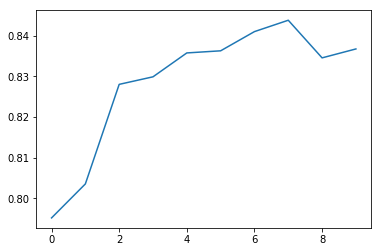

In [207]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [222]:
for n in [10, 20, 40, 80, 100]:
    m = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    m.fit(X_train, y_train)
    print_score(m)

[2.8887982994080135, 3.623001173060809, 0.9102917735504021, 0.7457739173253576]
[2.3727358505640743, 4.021252551548253, 0.9394803210303597, 0.6868114650828929]
[2.438647239212256, 3.7923605775295157, 0.9360713113830113, 0.7214504873772574]
[2.4278262140669815, 3.668258177922573, 0.9366373950128437, 0.7393828776839472]
[2.3655597829938633, 3.7080720597097354, 0.9398458371246631, 0.7336948980765997]


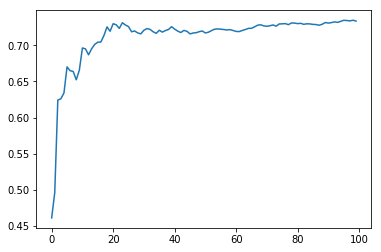

In [223]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(100)]);

**Results**

The `n_estimators`=100 seems to be better than the default of 10, although the data is definitely very random and different executions lead to different results.  But the plot of estimators shows that we don't peak until around 20-40 range, so it definitely pays to use more than 10.

### 3.3 Tree Building Parameters (`min_samples_leaf` and `max_features`)

Let's try varying the tree building parameters to create more variance in each decision tree, thereby improving the error rate of our random forest.

**Min Leaf Samples**

The first test is on `min_samples_leaf`. The results of 1,3,5,10,25 seem to get worse $R^2$ values. This is then confirmed by testing on the full set, where we get $R^2 = 0.78$ instead of $R^2 = 0.83$ on the default `min_samples_leaf` value of 1.

In [228]:
for n in [1, 3, 5, 10, 25]:
    m = RandomForestRegressor(n_estimators=10, n_jobs=-1, min_samples_leaf=n)
    m.fit(X_train, y_train)
    print_score(m)

m = RandomForestRegressor(n_estimators=10, n_jobs=-1, min_samples_leaf=5)
m.fit(X_train_full, y_train_full)
print_score(m)

[2.7119601307489676, 3.4474179951571484, 0.9209386124109963, 0.7698181666649794]
[4.627256930827338, 3.3851392793412733, 0.7698319383469918, 0.7780596633065805]
[5.686419229817797, 4.260712343232501, 0.6524033512092633, 0.6484010374853599]
[6.404868905215068, 4.563732220226669, 0.5590205807001856, 0.5966115452610505]
[7.218682442563223, 5.400383966795238, 0.4398379207365683, 0.43515090836775533]
[4.286122072116515, 4.696836893249292, 0.8025182791407649, 0.572738152862046]


**Max Features**

Using 0.5 or sqrt seems to be marginally better, so we tried it on the full set. The $R^2 = 0.844$ is marginally better than the $R^2 = 0.83$, so it's worth keeping this. 

In [229]:
for n in [None, 0.5, 0.25, 'sqrt', 'log2']:
    m = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_features=n)
    m.fit(X_train, y_train)
    print_score(m)

[2.35080127272915, 3.678555876065135, 0.9405940882823696, 0.73791759181446]
[2.674461192504593, 3.6589151397647908, 0.9231098988654247, 0.740708768441592]
[2.870876634149668, 4.732181051058803, 0.9114013932687522, 0.566283583738727]
[2.5518396436029454, 3.617084000499113, 0.9299989440578282, 0.7466036554899053]
[2.7770152264852808, 4.483759583206933, 0.9171000338577924, 0.6106252438160671]


In [230]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_features=0.5)
m.fit(X_train_full, y_train_full)
print_score(m)

[1.816666281002775, 2.836676605936367, 0.9645228975704127, 0.8441514340745044]


### 3.4 Putting it all together

Our (admittedly incomplete) tuned hyperparameters come out to:

* `n_estimators` = 40
* `min_samples_leaf` = 1 (the default)
* `max_features` = 0.5

The resulting $R^2 = 0.848$ which is pretty close to the initial results but hopefully will perform slightly better.

In [20]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_features=0.5, oob_score=True)
%time m.fit(X_train_full, y_train_full)
print_score(m)

CPU times: user 2min 37s, sys: 2.1 s, total: 2min 39s
Wall time: 43.8 s
[1.388459968214184, 2.7954167380881394, 0.9237471547056954, 0.8486521420277446, 0.7341725555874623]


## 4. Creating the submission

This Kaggle set is not trivial to create the submission because the test data is nothing like the training data. In order to create the submission, we will tweak `df_test` to match the expected input to the model, that is the current `df`.

In [31]:
df.head()

,ID,shop_id,item_id,item_category_id,item_price,date_month
0,88174,18,16146,64,1399.0,201301
1,19220,3,5272,30,599.0,201301
2,82894,16,16167,64,659.0,201301
3,178465,35,18589,37,999.0,201301
4,5122,4,5823,35,2500.0,201301


In [32]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [77]:
# merge with df to get item_category_id and item_price, taking last() item when removing duplicates to get latest price
df_test_merged = pd.merge(df_test, df.drop(['date_month'], axis=1), how='left', on=['ID', 'shop_id', 'item_id'], sort=True)
df_test_merged = df_test_merged.fillna(0)
df_test_merged = df_test_merged.groupby(['ID', 'shop_id', 'item_id', 'item_category_id']).last().reset_index()
# add in the month we are predicting for
df_test_merged['date_month'] = '201511'

In [79]:
df_test_merged.head()

,ID,shop_id,item_id,item_category_id,item_price,date_month
0,0,5,5037,19.0,749.5,201511
1,1,5,5320,0.0,0.0,201511
2,2,5,5233,19.0,1199.0,201511
3,3,5,5232,23.0,599.0,201511
4,4,5,5268,0.0,0.0,201511


In [80]:
submission = pd.DataFrame({'ID': df_test_merged['ID'], 'item_cnt_month': m.predict(df_test_merged)})
submission.head()

,ID,item_cnt_month
0,0,1.075
1,1,544.525
2,2,1.250
3,3,1.300
4,4,544.525


In [92]:
# turn all previously missing values (ID not in df) to 0 item_cnt_month
submission.loc[~submission.ID.isin(df.ID), ['item_cnt_month']] = 0

In [96]:
submission.to_csv('data/future_sales/real_submission.csv', index=False)

### 5. Conclusion

Sadly, this Random Forest model, despite having a decent $R^2$ value, has a pretty bad RMSE, and therefore is not an improvement over the sample submission of all 0.5 values.

Why? We probably don't have enough features to make a valid prediction. I am guessing the high-value predictions are using analysis on the item or shop names, rather than operating solely on the `item_price` and `item_category_id`.

After doing some research, I found (this blog post)[https://www.kaggle.com/szhou42/predict-future-sales-top-11-solution] which confirms that my issue is feature related, not model related. Their initial RMSE was around the same as mine, but then they did some category massaging (collapsing overly specific categories into broad categories) and feature engineering. This feature engineering is something I haven't encountered yet, but it makes sense that Random won't be able to find such interactions. However, many people also suggest using a time-series based model like XGBoost rather than Random Forest, but I don't yet know enough to understand if that is important for this problem.